<a href="https://www.kaggle.com/code/mohamedmaher5/car-object-detection?scriptVersionId=165307355" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install imgaug

In [2]:
import pandas as pd

cars_images_path = '/kaggle/input/car-object-detection/annotation_car_train.csv'

cars_df = pd.read_csv(cars_images_path)
cars_df.head()

xmin  ymin  xmax  ymax name      file  width  height  class     Xcent  \
0  1649  1179  2363  1787  car  img_2297   4032    3024    NaN  0.497520   
1  1693  1315  2097  1660  car  img_2745   4032    3024    NaN  0.469990   
2  1638  1296  2145  1721  car  img_1707   4032    3024    NaN  0.469122   
3  1412  1152  2373  1910  car  img_2665   4032    3024    NaN  0.469370   
4  1732  1401  2405  1952  car  img_1712   4032    3024    NaN  0.513021   

      Ycent      boxW      boxH  
0  0.490410  0.177083  0.201058  
1  0.491898  0.100198  0.114087  
2  0.498843  0.125744  0.140542  
3  0.506283  0.238343  0.250661  
4  0.554398  0.166915  0.182209

In [3]:
len(cars_df)

482

In [4]:
cars_df = cars_df.drop_duplicates()
len(cars_df)

482

In [5]:
# Drop columns
columns_to_drop = ['class', 'Xcent','Ycent','boxW','boxH']
cars_df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# Rename columns
new_column_names = {
    'name': 'label'
}
cars_df.rename(columns=new_column_names, inplace=True)

In [7]:
cars_df.head()

xmin  ymin  xmax  ymax label      file  width  height
0  1649  1179  2363  1787   car  img_2297   4032    3024
1  1693  1315  2097  1660   car  img_2745   4032    3024
2  1638  1296  2145  1721   car  img_1707   4032    3024
3  1412  1152  2373  1910   car  img_2665   4032    3024
4  1732  1401  2405  1952   car  img_1712   4032    3024

In [8]:
# Count occurrences of each unique height value
height_counts = cars_df['height'].value_counts()
width_counts = cars_df['width'].value_counts()

print("Number of images with specific heights:")
print(height_counts,"\n")

print("Number of images with specific width:")
print(width_counts)

Number of images with specific heights:
height
3024    481
4032      1
Name: count, dtype: int64 

Number of images with specific width:
width
4032    481
3024      1
Name: count, dtype: int64


In [9]:
label_counts = cars_df['label'].value_counts()
label_counts

label
car    482
Name: count, dtype: int64

In [10]:
import cv2
import numpy as np
import os
import glob as gb

def resize_image_and_boxes(row, images_folder, new_size):

    try:
        # Load image
        image_path = images_folder+"/"+ row['file']+".jpg"
        image = cv2.imread(image_path)

        if image is None:
            raise ValueError(f"Failed to load image from: {image_path}")

        # Resize image
        resized_image = cv2.resize(image, new_size)

        # Calculate scaling factors
        scale_x = new_size[1] / image.shape[1]
        scale_y = new_size[0] / image.shape[0]

        # Extract bounding box coordinates from DataFrame row
        x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        # Adjust bounding boxes
        x_min_resized = int(x_min * scale_x)
        y_min_resized = int(y_min * scale_y)
        x_max_resized = int(x_max * scale_x)
        y_max_resized = int(y_max * scale_y)
        resized_boxes = [x_min_resized, y_min_resized, x_max_resized, y_max_resized]

        # resized_image_label = get_code(row['label'])

        return resized_image, resized_boxes,
        # resized_image_label

    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [11]:
cars_images_folder = "/kaggle/input/car-object-detection/train"  # Path to the folder containing images
new_size = (224, 224)  # New size for the resized image

In [12]:
resized_images = []
resized_boxes_list = []

for index, row in cars_df.iterrows():
    resized_image, resized_boxes = resize_image_and_boxes(row, cars_images_folder, new_size)
    # Check if resizing was successful
    if resized_image is not None and resized_boxes is not None:
        resized_images.append(resized_image)
        resized_boxes_list.append(resized_boxes)
        # resized_images_labels.append(resized_image_label)
    else:
        print(f"Skipping row {index}: Failed to resize image or adjust bounding boxes.")

In [13]:
# Convert lists to numpy arrays
resized_cars_images_array = np.array(resized_images)
resized_cars_boxes_array = np.array(resized_boxes_list)

# Check the shape of the resized images array
print("Shape of resized images array:", resized_cars_images_array.shape)

Shape of resized images array: (482, 224, 224, 3)


In [14]:
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def augment_image(image, bboxes, flip_probability=0.5, crop_percent=0.1, blur_sigma=0.5,
                  contrast_range=(0.75, 1.5), noise_scale=(0.0, 0.05*255), brightness_range=(0.8, 1.2),
                  scale_range=(0.8, 1.2), translate_percent=(-0.2, 0.2), rotation_range=(-45, 45),
                  shear_range=(-16, 16)):
    seq = iaa.Sequential([
        iaa.Fliplr(flip_probability),
        iaa.Crop(percent=(0, crop_percent)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, blur_sigma))),
        iaa.ContrastNormalization(contrast_range),
        iaa.AdditiveGaussianNoise(loc=0, scale=noise_scale, per_channel=0.5),
        iaa.Multiply(brightness_range, per_channel=0.2),
        iaa.Affine(
            scale={"x": scale_range, "y": scale_range},
            translate_percent={"x": translate_percent, "y": translate_percent},
            rotate=rotation_range,
            shear=shear_range,
            order=[0, 1],
            cval=(0, 255),
        )
    ], random_order=True)

    bounding_boxes = [BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3]) for bbox in bboxes]
    bbs = BoundingBoxesOnImage(bounding_boxes, shape=image.shape)

    augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)

    augmented_bboxes = [[bb.x1, bb.y1, bb.x2, bb.y2] for bb in augmented_bbs.bounding_boxes]

    return augmented_image, augmented_bboxes

In [15]:
augmented_images = []
augmented_bboxes = []

for image, boxes in zip(resized_cars_images_array, resized_cars_boxes_array):
    augmented_image, augmented_boxes = augment_image(image, [boxes])
    # Check if augmentation was successful
    if augmented_image is not None and augmented_boxes is not None:
        augmented_images.append(augmented_image)
        augmented_bboxes.append(augmented_boxes[0])  # Since the function returns a list of boxes, we extract the first one
    else:
        print("Skipping augmentation for an image.")

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [16]:
# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_bboxes = np.array(augmented_bboxes)

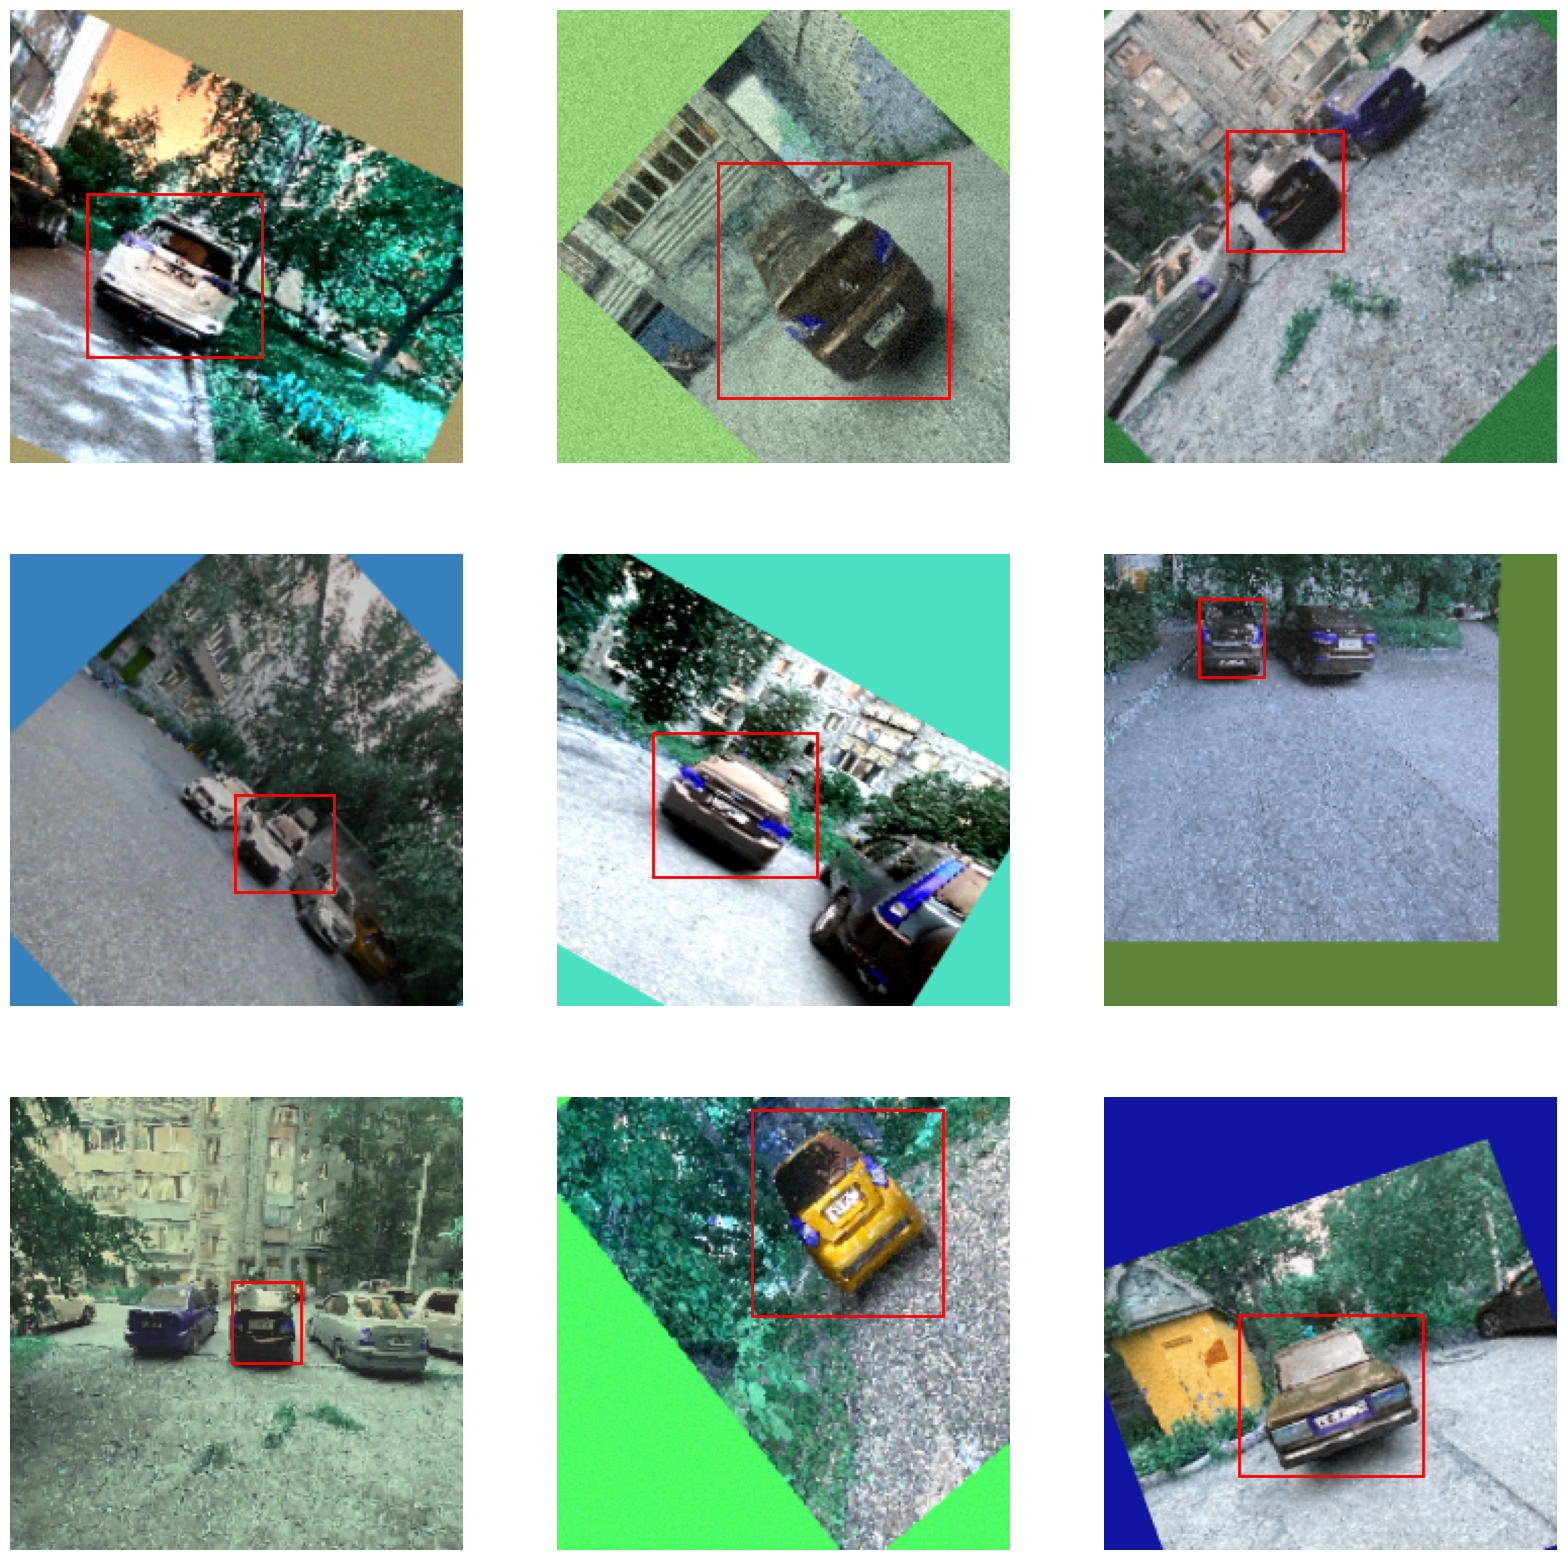

In [17]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 20))

for n, i in enumerate(random.sample(range(len(augmented_images)), 9)):
    ax = plt.subplot(3, 3, n+1)
    ax.imshow(augmented_images[i])
    ax.axis('off')

    x_min = augmented_bboxes[i][0]
    y_min =  augmented_bboxes[i][1]
    x_max =  augmented_bboxes[i][2]
    y_max =  augmented_bboxes[i][3]

    # Draw bounding boxes
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [18]:
concatenated_images = np.concatenate((resized_cars_images_array, augmented_images))
concatenated_boxes = np.concatenate((resized_cars_boxes_array, augmented_bboxes))

In [19]:
concatenated_images.shape,concatenated_boxes.shape

((964, 224, 224, 3), (964, 4))

In [20]:
len(concatenated_boxes), len(concatenated_images)

(964, 964)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(concatenated_images, concatenated_boxes, test_size=0.2, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=321)

In [22]:
len(X_train),len(X_val),len(X_test)

(771, 96, 97)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np

def create_faster_rcnn_model():
    # Load the pre-trained ResNet50 backbone
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers for classification and regression
    x = layers.GlobalAveragePooling2D()(base_model.output)
    bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(x)  # Output layer for bounding box regression

    # Create the model
    model = Model(inputs=base_model.input, outputs=[bbox_output])

    return model

2024-03-03 21:18:06.868279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 21:18:06.868390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 21:18:07.152925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
import tensorflow as tf

def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), tf.float32)
    loss = (less_than_one * 0.5 * diff ** 2) + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss, axis=-1)

In [25]:
import tensorflow as tf

def iou(y_true, y_pred):
    # Cast tensors to float32 to ensure compatibility
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Extract bounding box coordinates from y_true and y_pred
    true_x1, true_y1, true_x2, true_y2 = tf.split(y_true, num_or_size_splits=4, axis=-1)
    pred_x1, pred_y1, pred_x2, pred_y2 = tf.split(y_pred, num_or_size_splits=4, axis=-1)

    # Calculate coordinates of intersection area
    x1 = tf.maximum(true_x1, pred_x1)
    y1 = tf.maximum(true_y1, pred_y1)
    x2 = tf.minimum(true_x2, pred_x2)
    y2 = tf.minimum(true_y2, pred_y2)

    # Calculate area of intersection rectangle
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # Calculate area of true and predicted bounding boxes
    true_area = (true_x2 - true_x1) * (true_y2 - true_y1)
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)

    # Calculate IoU
    iou = intersection / (true_area + pred_area - intersection + tf.keras.backend.epsilon())
    return tf.reduce_mean(iou)

In [26]:
def create_model(learning_rate=0.001):
    model = create_faster_rcnn_model()  # Replace with your function to create the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss={'bbox_output': smooth_l1_loss},metrics=[iou])
    return model

In [27]:
model = create_model()

94765736/94765736 [==============================] - 0s 0us/step


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs = 15
save_best = ModelCheckpoint('best_weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [29]:
# Fit the grid search with training and validation data
history = model.fit(X_train, y_train,
                    batch_size= 1,
                    epochs= epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[save_best]
)

Epoch 1/15
  5/771 [..............................] - ETA: 11s - loss: 115.7251 - iou: 0.0000e+00   

I0000 00:00:1709500716.269151      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


771/771 [==============================] - 17s 11ms/step - loss: 28.9216 - iou: 0.2214 - val_loss: 21.6538 - val_iou: 0.2770
Epoch 2/15
771/771 [==============================] - 7s 9ms/step - loss: 18.0929 - iou: 0.3286 - val_loss: 19.0202 - val_iou: 0.3133
Epoch 3/15
771/771 [==============================] - 7s 9ms/step - loss: 16.2938 - iou: 0.3630 - val_loss: 17.6004 - val_iou: 0.3438
Epoch 4/15
771/771 [==============================] - 7s 9ms/step - loss: 14.9922 - iou: 0.3873 - val_loss: 16.6703 - val_iou: 0.3700
Epoch 5/15
771/771 [==============================] - 7s 9ms/step - loss: 13.9116 - iou: 0.4147 - val_loss: 15.6594 - val_iou: 0.3898
Epoch 6/15
771/771 [==============================] - 7s 9ms/step - loss: 13.1359 - iou: 0.4315 - val_loss: 14.9426 - val_iou: 0.4019
Epoch 7/15
771/771 [==============================] - 7s 9ms/step - loss: 12.4922 - iou: 0.4471 - val_loss: 14.5909 - val_iou: 0.4147
Epoch 8/15
771/771 [==============================] - 7s 10ms/step - lo

In [30]:
def compute_accuracy(predicted_boxes, true_boxes):
    total_iou = 0.0
    num_samples = len(predicted_boxes)

    for predicted_box, true_box in zip(predicted_boxes, true_boxes):
        # Compute IoU for the current predicted box and true box
        iou_score = iou(predicted_box, true_box)  # Use your custom IOU function
        total_iou += iou_score

    # Calculate average IoU across all samples
    average_iou = total_iou / num_samples

    # Calculate accuracy (IoU is typically used as a measure of accuracy for object detection)
    accuracy = average_iou

    return accuracy

In [31]:
predicted_boxes = model.predict(X_test)
true_boxes = y_test

4/4 [==============================] - 4s 62ms/step


In [32]:
# Compute accuracy using the compute_accuracy function
accuracy = compute_accuracy(predicted_boxes, true_boxes)

In [33]:
accuracy_value = accuracy.numpy()
print("Accuracy:", accuracy_value)

Accuracy: 0.41014075


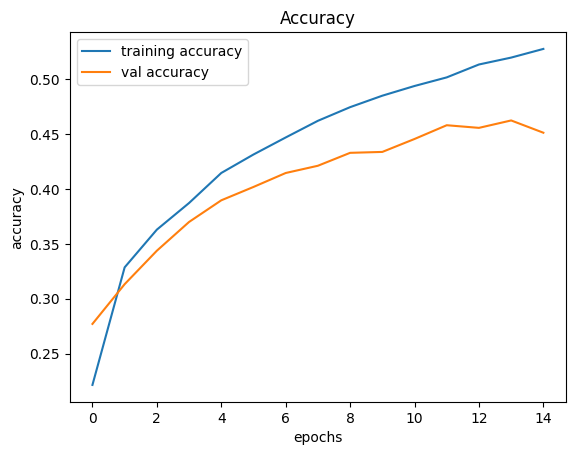

In [34]:
## Accuracy Curve
plt.figure(0)
plt.plot(history.history['iou'], label='training accuracy')
plt.plot(history.history['val_iou'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

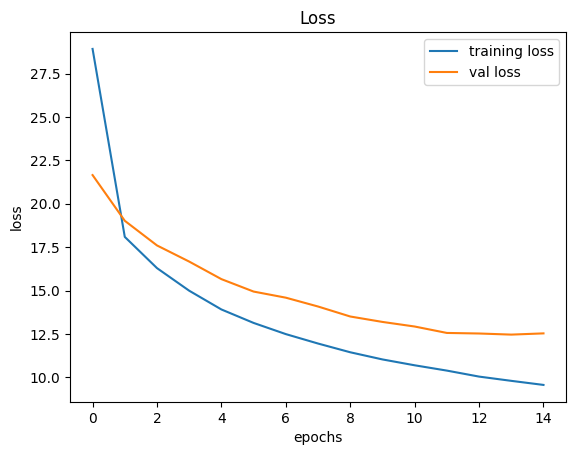

In [35]:
## Loss Curve
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

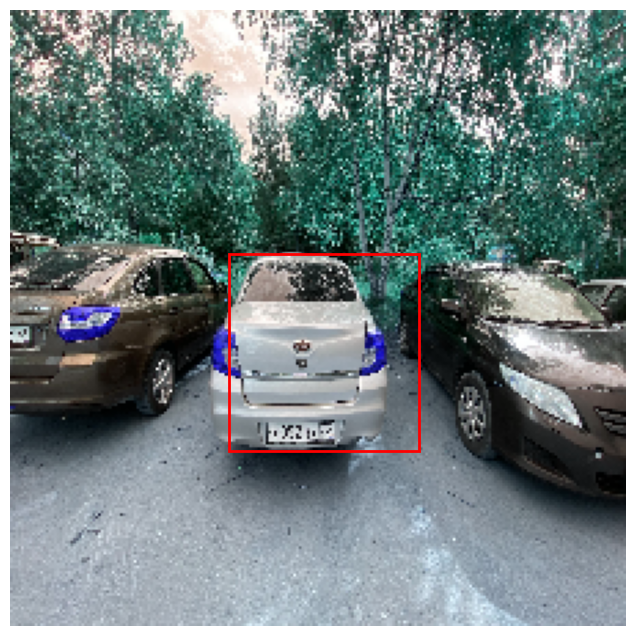

In [36]:
import matplotlib.pyplot as plt

index1 = 15

plt.figure(figsize=(8, 8))
plt.imshow(X_test[index1])
plt.axis('off')

x_min = predicted_boxes[index1][0]
y_min = predicted_boxes[index1][1]
x_max = predicted_boxes[index1][2]
y_max = predicted_boxes[index1][3]

rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

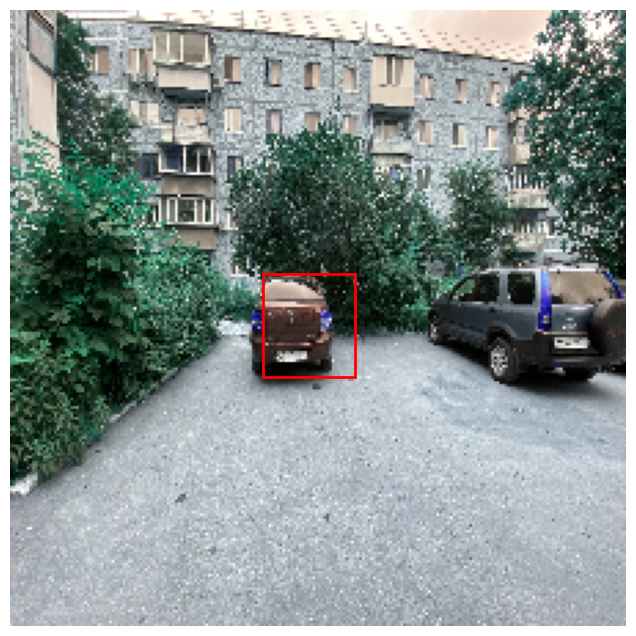

In [37]:
import matplotlib.pyplot as plt

index2 = 30
plt.figure(figsize=(8, 8))

# Display the image
plt.imshow(X_test[index2])
plt.axis('off')

# Retrieve bounding box coordinates
x_min = predicted_boxes[index2][0]
y_min = predicted_boxes[index2][1]
x_max = predicted_boxes[index2][2]
y_max = predicted_boxes[index2][3]

# Draw bounding box
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()